# Intro to raytracing in python
Welcome to this introduction to ray tracing using the worlds most beautiful programing language, Python.
In this introduction we will build a ray-tracer.
This ray-tracer will only feature basic features, but understanding these is essential for doing more advanced ray-tracing work.
Although Python is awesome, it might not be the 'ideal' language for a ray tracer. It is however very readable. So if you want to program your own ray-tracer, by all means, do it in C or C++.
The number crunching performance of C/C++ 


## Part 1: In the beginning there was only triangles and rays

The 2 fundamental parts of a ray-tracer would be rays and triangles.

In the world of computer graphics, triangles are a great way to create 3D models. Using sufficiently many triangles could yield any 3D shape that you would ever want (even if sufficiently many can mean "infinitly many" with curved surfaces, but if you use enough, know one will be able to tell the difference. It will look just like a curved surface, and that its just triangles can stay our little secret!)
The easies way to define a triangle is by means of its corner positions. That is all info that we need right now!

![sphere from triangles](https://i.stack.imgur.com/RhJgj.gif)

To simulate light, we need to be able to simulate light rays. Because this is a basic ray-tracer, we will do something that might seem a bit weird. instead of sending "photons" from our lamps and seeing how they fall onto the camera, as would happen in the real world, we will do the opposite. We start  from the camera's point of view and look at the scene.

![Tracing from the camera](https://www.scratchapixel.com/images/upload/ray-tracing-refresher/rt-setup2.png?)

Lets start with a simple triangle class

In [2]:
class Triangle():
    def __init__(self, a, b, c):
        '''
        Basic triangle class.
        :param a: First corner
        :param b: Second corner
        :param c: Third corner
        '''
        self.a = a
        self.b = b
        self.c = c

Now we need the simple ray class


In [ ]:
class Ray:
    def __init__(self, origin, direction):
        '''
        Basic ray class.
        :param origin: Origin/starting point of the ray
        :param direction: Direction of the ray
        '''
        self.origin = origin
        self.direction = direction
        


We already have our 2 most important classes!
It is time to move towards creating our first test image as soon as possible right?

Well, we will get there soon, I promise. But first, we need 4 more features for our ray-tracer.

## Part 2: When suddenly a wild camera appeared
The features that we need are:
- A little bit vector magic
- Ray triangle intersection testing
- A ray tracing function
- A camera 

We need some way to represent points in our virtual world. Vectors are a nice solution for ray tracing. Using vectors we can define triangles, and rays! We can even use it to locate our camera in the world ones we made a camera.
This is not a linear algebra course however, so I added a little MathUtil library to this project, which we can just import. Feel free to look into the MathUtil.py file if you want to learn more about the implementation of vectors.

Lets import the library and give some examples:

In [4]:
from math import *
from MathUtil import *

# Point_a is a point with:
# x = 1, y = 2, z = 3
point_a = Vec3(1,2,3)

# Point_b is a point with:
# x = -1, y = 5, z = 0
point_b = Vec3(-1,5,0)

# You can subtract vectors
point_c = point_a-point_b
print(f"Point_c: {point_c}")

# Or calculate the distance
dist = point_a.distance(point_b)
print(f"distamce: {dist}")

Vec3<2 -3 3>


There are quite some operations which we can do with vectors, and there are even 2D vectors in the Math Util library (named Vec2, as you might have guessed). I wont list them all here, but we will just use them when we need them.


Ray triangle intersection testing will be a bit more work, but this is the first interesting part!
![ray triangle intersection](https://la.mathworks.com/matlabcentral/mlc-downloads/downloads/submissions/49670/versions/3/screenshot.jpg)




In [ ]:
def ray_triangle_intersect(self, other):
    '''
    Test if the ray hits the triangle.
    :param self: The ray
    :param other: The triangle
    :return: Distance to triangle, 0/False is no hit
    '''
    
    # Calculate the vectors describing the edges of the triangle
    edge1 = other.b - other.a
    edge2 = other.c - other.a
    
    # Check if the ray and triangle are not parallel
    h = self.direction.cross_product(edge2)
    a = edge1.dot(h)

    if -EPSILON < a < EPSILON:
        return False
    
    # Calculate U/V (barycentric coordinates) of the hit on the triangle
    f = 1.0 / a
    s = self.origin - other.a
    u = f * (s.dot(h))
    
    q = s.cross_product(edge1)
    v = f * self.direction.dot(q)

    # The U must be between 0 and one
    if u < 0 or u > 1:
        return False
    
    # The V must be larger than 0, and U+V must be smaller than one
    if v < 0 or u + v > 1:
        return False
    
    # Calculate the distance from the origin of the ray to the hit
    t = f * edge2.dot(q)

    # The distance must be positive because,
    # otherwise the triangle could be behind the ray
    if t < EPSILON:
        return False
    
    # There was a hit! Return the distance
    return t


We now need to add this function to the Ray class.
Adding functions to a class outside of the class definition might not be the cleanest thing to do, but it does the trick.
This is called "monkey patching".
im using a separate code cell for this right now, but in the future, if I make a function that should be in a class, I will do so just after the function definition. 

In [ ]:
Ray.triangle_intersection_test = ray_triangle_intersect

Now we need the "Ray tracing function"
This will be the function which receives a ray, and returns the output colour.
We will start with a really basic function which just returns black when it hits nothing, and white if it hits a triangle.

In [ ]:
def trace_ray(ray, triangles):
    '''
    Returns the color of the ray.
    White = hit
    Black = miss 
    :param ray: Ray that has been shot into the world
    :param triangles: list of triangles in the world
    :return: color
    '''
    
    # Loop over all triangles
    for tri in triangles:
        # And if there is a hit
        if ray.triangle_intersection_test(tri):
            # Return white
            return Vec3(1.0)
    # Else, return black
    return Vec3(0.0)

Now the only thing that we need is a camera!
The camera will loop over all all the directions that it look at, as is illustrated in the second picture.
for each of the directions, it will call the ray trace function, and safe the result.
When its done it will show the image!
We will use matplotlib for this


In [ ]:
from matplotlib import pyplot as plt

def camera(camera_pos, width, height, fov, triangles):
    '''
    Renders a image of width*height pixels, of the world of triangles.
    As seen from the camera position
    The field of view is how "wide" the lens is.
    :param camera_pos: camera position
    :param width: horizontal pixels
    :param height: vertical pixels
    :param fov: field of view
    :param triangles: triangles in the world
    '''
    
    image = []
    
    angle = tan(pi * 0.5 * fov / 180)
    aspect_ratio = width / height
    inv_width = 1/width
    inv_height = 1/height
    
    # For all pixels of the image
    for y in range(height):
        row = []
        for x in range(width):
            # Calculate the direction of the ray for this pixel
            xdir = (2 * x * inv_width - 1) * angle * aspect_ratio
            ydir = (1 - 2 * y * inv_height) * angle
            
            raydir = Vec3(xdir, ydir, 1)
            raydir.normalize()
            
            # Create the ray
            ray = Ray(camera_pos, raydir)
            
            # Trace the ray, and convert color from Vec3 to [r,g,b]
            col = trace_ray(ray, triangles).toList()
            row.append(col)
        image.append(row)
    
    plt.imshow(image)
    plt.show()
    

Now that we have all the basic stuff done, we already have a little "mini ray-tracer"!
Whe should test it :)

In [ ]:
triangles = [Triangle(Vec3(-1,-1,3),Vec3(1,-1,3),Vec3(0,1,3))]
camera(Vec3(0),100,100,60,triangles)

Congratulations! We have our first triangle!

To conclude this part 2, we will make the ray tracing function a little bit more fun as a bonus.
The further a triangle is, the darker we will shade it.

For this it is important that we look at the first triangle that a ray hits.

In [22]:
def trace_ray(ray, triangles):
    '''
    Returns the color of the ray.
    Color changes depending on the distance to the hit
    :param ray: Ray that has been shot into the world
    :param triangles: list of triangles in the world
    :return: color
    '''
    
    has_hit = False
    closest_hit = inf
    
    # Loop over all triangles
    for tri in triangles:
        # And if there is a hit
        t = ray.triangle_intersection_test(tri)
        if t:
            # Take note of the closest one
            has_hit = True
            closest_hit = min(closest_hit,t)
    
    # If there is a hit, return the color based on the distance
    if has_hit:
        return Vec3(1.0)/closest_hit
    # Else, return black
    return Vec3(0.0)

To test this we will use a world with 3 triangles

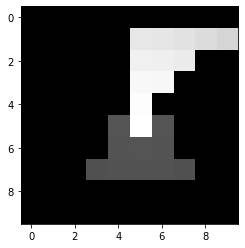

[[[0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0]],
 [[0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.9078412990032035, 0.9078412990032035, 0.9078412990032035],
  [0.902893898143269, 0.902893898143269, 0.902893898143269],
  [0.8885233166386385, 0.8885233166386385, 0.8885233166386385],
  [0.8660254037844385, 0.8660254037844385, 0.8660254037844385],
  [0.8372183582789214, 0.8372183582789214, 0.8372183582789214]],
 [[0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.9449111825230682, 0.9449111825230682, 0.9449111825230682],
  [0.9393364366277243, 0.9393364366277243, 0.9393364366277243],
  [0.9231861823449954, 0.9231861823449954, 0.9231861823449954],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0]],
 [[0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 

In [24]:

triangles = [Triangle(Vec3(-1,-1,3),Vec3(1,-1,3),Vec3(0,1,3)),
             Triangle(Vec3(0.5,0.5,1),Vec3(0.1,0.5,1),Vec3(0.1,0,1)),
             Triangle(Vec3(-2,1,5),Vec3(1,0-1,5),Vec3(4,1,5))]
camera(Vec3(0),100,100,60,triangles)

Now that we have a basic ray-tracer, we are ready to continue our journey to more advanced topics!
